In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import collections as co
import itertools as it

In [33]:
from sklearn import (datasets,
                     dummy,
                     linear_model,
                     metrics,
                     model_selection as skms,
                     neighbors,
                     pipeline,
                     preprocessing as skpre)

In [34]:
from sklearn.model_selection import train_test_split
import sklearn.model_selection as skms

diabetes = datasets.load_diabetes()

tts = skms.train_test_split(diabetes.data,
                           diabetes.target,
                           test_size=.25,
                           random_state=42)

(diabetes_train_ftrs, diabetes_test_ftrs,
diabetes_train_tgt, diabetes_test_tgt) = tts

In [35]:
from sklearn.dummy import DummyRegressor

baseline = dummy.DummyRegressor(strategy='median')

In [36]:
strategies = ['constant', 'quantile', 'mean', 'median', ]
baseline_args = [{"strategy":s} for s in strategies]

baseline_args[0]['constant'] = 50.0
baseline_args[1]['quantile'] =  0.75

def do_one_diabetes(**args):
    baseline = dummy.DummyRegressor(**args)
    baseline.fit(diabetes_train_ftrs, diabetes_train_tgt)
    base_preds = baseline.predict(diabetes_test_ftrs)
    return metrics.mean_squared_error(base_preds, diabetes_test_tgt)

mses = [do_one_diabetes(**bla) for bla in baseline_args]

display(pd.DataFrame({'mse':mses,
                      'rmse':np.sqrt(mses)}, 
                     index=strategies))

,mse,rmse
constant,14657.684685,121.068925
quantile,10216.387387,101.076146
mean,5607.197931,74.881225
median,5542.225225,74.446123


In [37]:
def rms_error(actual, predicted):
    ' root-mean-squared-error function '
    
    mse = metrics.mean_squared_error(actual, predicted)
    return np.sqrt(mse)

def neg_rmse_score(actual, predicted):
    ' rmse based score function '
    
    return -rms_error(actual, predicted)

def neg_rmse_scorer(model, ftrs, tgt_actual):
    ' rmse scorer suitable for scoring arg '
    tgt_pred = model.predict(ftrs)
    return neg_rmse_score(tgt_actual, tgt_pred)

In [38]:
knn = neighbors.KNeighborsRegressor(n_neighbors=3)
skms.cross_val_score(knn, diabetes.data, diabetes.target,
                     scoring=neg_rmse_scorer)

array([-58.07341774, -67.43002106, -62.28861222, -62.02315061,
       -67.25015489])

In [39]:
lr = linear_model.LinearRegression()

print(lr.score.__doc__.splitlines()[0])

Return the coefficient of determination of the prediction.


In [40]:
our_preds = np.array([1, 2, 3])
mean_preds = np.array([2, 2, 2])
actual = np.array([2, 3, 4])

sse_ours = np.sum(( our_preds - actual)**2)
sse_mean = np.sum((mean_preds - actual)**2)

In [41]:
r_2 = 1 - (sse_ours / sse_mean)
print("manual r2:{:5.2f}".format(r_2))

manual r2: 0.40


In [43]:
baseline = DummyRegressor(strategy='mean')

baseline.fit(diabetes_train_ftrs, diabetes_train_tgt)
base_preds = baseline.predict(diabetes_test_ftrs)

base_r2_sklearn = metrics.r2_score(diabetes_test_tgt, base_preds)

print(base_r2_sklearn)

-0.014016723490579253


In [45]:
base_errors = base_preds - diabetes_test_tgt
sse_base_preds = np.dot(base_errors, base_errors)

train_mean_errors = np.mean(diabetes_train_tgt) - diabetes_test_tgt
sse_mean_train = np.dot(train_mean_errors, train_mean_errors)

test_mean_errors = np.mean(diabetes_test_tgt) - diabetes_test_tgt
sse_mean_test = np.dot(test_mean_errors, test_mean_errors)

In [46]:
(sse_base_preds / sse_mean_test)

1.0140167234905788

In [47]:
print(base_r2_skylearn)
print(1 - (sse_base_preds / sse_mean_test))

-0.014016723490579253
-0.014016723490578809


In [50]:
def get_model_name(model):
    return model.__class__.__name__

testbase = DummyRegressor(strategy='mean')
testbase.fit(diabetes_test_ftrs, diabetes_test_tgt)
testbase_preds = testbase.predict(diabetes_test_ftrs)
testbase_mse = metrics.mean_squared_error(testbase_preds, diabetes_test_tgt)

models = [neighbors.KNeighborsRegressor(n_neighbors=3),
          linear_model.LinearRegression()]

results = dict()
for m in models:
    preds = m.fit(diabetes_train_ftrs, diabetes_train_tgt).predict(diabetes_test_ftrs)
    mse = metrics.mean_squared_error(preds, diabetes_test_tgt)
    r2 = metrics.r2_score(diabetes_test_tgt, preds)
    results[get_model_name(m)] = {'R^2': r2, 'MSE': mse}

print(testbase_mse)
df = pd.DataFrame(results).T
df['Norm_MSE'] = df['MSE'] / testbase_mse
df['1-R^2'] = 1 - df['R^2']
display(df)

5529.689797906013


,R^2,MSE,Norm_MSE,1-R^2
KNeighborsRegressor,0.372222,3471.419419,0.627778,0.627778
LinearRegression,0.484909,2848.295308,0.515091,0.515091


In [51]:
ape_df = pd.DataFrame({'predicted' : [4, 2, 9],
                       'actual'    : [3, 5, 7]})

ape_df['error'] = ape_df['predicted'] - ape_df['actual']

ape_df.index.name = 'example'
display(ape_df)

,predicted,actual,error
example,,,
0,4,3,1
1,2,5,-3
2,9,7,2


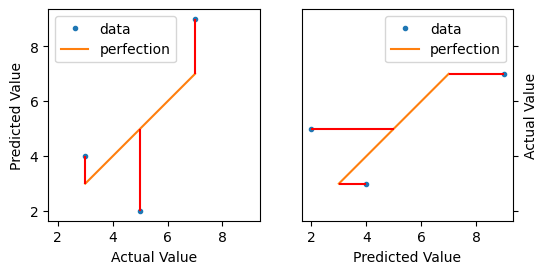

In [54]:
def regression_errors(figsize, predicted, actual, errors='all'):
    fig, axes = plt.subplots(1,2, figsize=figsize, sharex=True, sharey=True)
    df = pd.DataFrame({'actual':actual, 'predicted':predicted})
    
    for ax, (x,y) in zip(axes, it.permutations(['actual', 'predicted'])):
        ax.plot(df[x], df[y], '.', label='data')
        ax.plot(df['actual'], df['actual'], '-', label='perfection')
        ax.legend()
        ax.set_xlabel('{} Value'.format(x.capitalize()))
        ax.set_ylabel('{} Value'.format(y.capitalize()))
        ax.set_aspect('equal')
    
    axes[1].yaxis.tick_right()
    axes[1].yaxis.set_label_position("right")
    
    if errors == 'all':
        errors = range(len(df))
        
    if errors:
        acts = df.actual.iloc[errors]
        preds = df.predicted.iloc[errors]
        axes[0].vlines(acts, preds, acts, 'r')
        axes[1].hlines(acts, preds, acts, 'r')

regression_errors((6,3), ape_df.predicted, ape_df.actual)

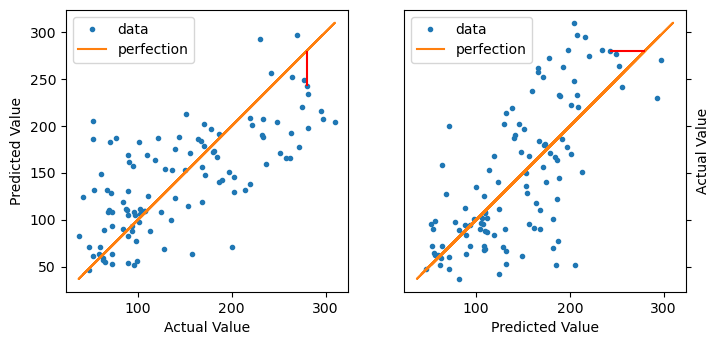

In [55]:
lr  = linear_model.LinearRegression()
preds = (lr.fit(diabetes_train_ftrs, diabetes_train_tgt)
           .predict(diabetes_test_ftrs))

regression_errors((8,4), preds, diabetes_test_tgt, errors=[-20]) 

In [56]:
ape_df = pd.DataFrame({'predicted' : [4, 2, 9],
                       'actual'    : [3, 5, 7]})

ape_df['error'] = ape_df['predicted'] - ape_df['actual']
ape_df['resid'] = ape_df['actual'] - ape_df['predicted']

ape_df.index.name = 'example'
display(ape_df)

,predicted,actual,error,resid
example,,,,
0,4,3,1,-1
1,2,5,-3,3
2,9,7,2,-2


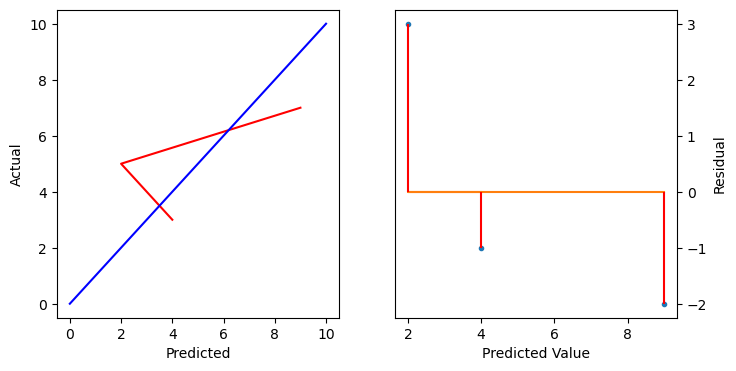

In [58]:
def regression_residuals(ax, predicted, actual, show_errors=None, right=False):
    df = pd.DataFrame({'actual': actual, 'predicted': predicted})
    df['error'] = df.actual - df.predicted
    ax.plot(df.predicted, df.error, '.')
    ax.plot(df.predicted, np.zeros_like(predicted), '-')

    if right:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        ax.set_xlabel('Predicted Value')
        ax.set_ylabel('Residual')

        if show_errors == 'all':
            show_errors = range(len(df))
        if show_errors:
            preds = df.predicted.iloc[show_errors]
            errors = df.error.iloc[show_errors]
            ax.vlines(preds, 0, errors, 'r')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.plot(ape_df.predicted, ape_df.actual, 'r', [0, 10], [0, 10], 'b-')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
regression_residuals(ax2, ape_df.predicted, ape_df.actual, 'all', right=True)

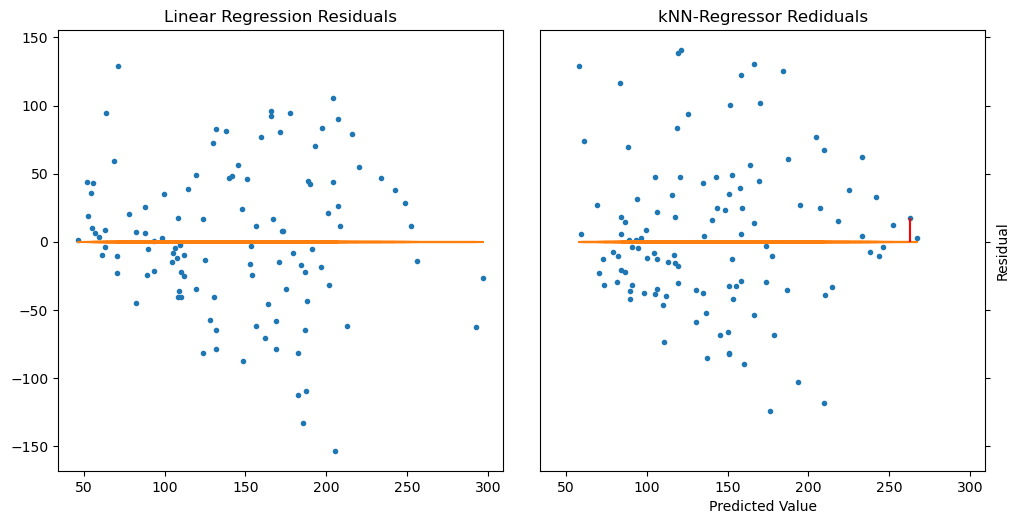

In [59]:
lr  = linear_model.LinearRegression()
knn = neighbors.KNeighborsRegressor()

models = [lr, knn]

fig, axes = plt.subplots(1, 2, figsize=(10,5), 
                         sharex=True, sharey=True)
fig.tight_layout()

for model, ax, on_right in zip(models, axes, [False, True]):
    preds = (model.fit(diabetes_train_ftrs, diabetes_train_tgt)
                  .predict(diabetes_test_ftrs))
    
    regression_residuals(ax, preds, diabetes_test_tgt, [-20], on_right)

axes[0].set_title('Linear Regression Residuals')
axes[1].set_title('kNN-Regressor Rediduals');

In [60]:
print(diabetes_test_tgt[-20])

280.0


,x,std-ized
mean,2.500000,6.661338e-17
std,4.670589,1.000000e+00


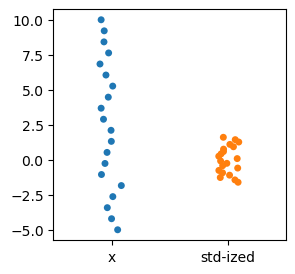

In [61]:
xs = np.linspace(-5, 10, 20)
df = pd.DataFrame(xs, columns=['x'])

df['std-ized'] = (df.x - df.x.mean()) / df.x.std()

fig, ax = plt.subplots(1,1,figsize=(3,3))
sns.stripplot(data=df)
display(df.describe().loc[['mean', 'std']])

In [62]:
xs = np.linspace(-5, 10, 20)
ys = 3*xs + 2 + np.random.uniform(20, 40, 20)

print("First Row Values")
df = pd.DataFrame({'x':xs, 'y':ys})
display(df.head())

print("Standardized")
df_std_ized = (df - df.mean()) / df.std()
display(df_std_ized.describe().loc[['mean', 'std']])

First Row Values


,x,y
0,-5.000000,12.086097
1,-4.210526,23.230352
2,-3.421053,21.915013
3,-2.631579,15.983580
4,-1.842105,22.757979


Standardized


,x,y
mean,6.661338e-17,-3.552714e-16
std,1.000000e+00,1.000000e+00


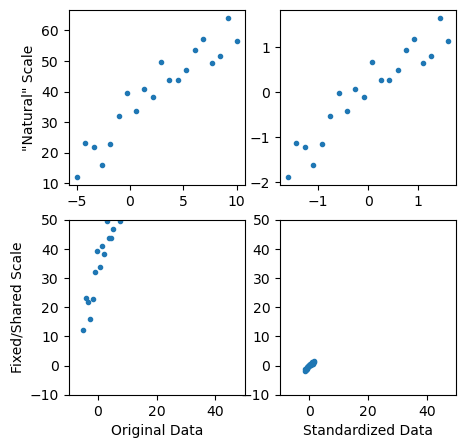

In [63]:
fig, ax = plt.subplots(2,2, figsize=(5,5))

ax[0,0].plot(df.x, df.y, '.')
ax[0,1].plot(df_std_ized.x, df_std_ized.y, '.')
ax[0,0].set_ylabel('"Natural" Scale')

ax[1,0].plot(df.x, df.y, '.')
ax[1,1].plot(df_std_ized.x, df_std_ized.y, '.')

ax[1,0].axis([-10, 50, -10, 50])
ax[1,1].axis([-10, 50, -10, 50])

ax[1,0].set_ylabel('Fixed/Shared Scale')
ax[1,0].set_xlabel('Original Data')
ax[1,1].set_xlabel('Standardized Data');

In [64]:
train_xs, test_xs = skms.train_test_split(xs.reshape(-1,1), test_size=.5)

scaler = skpre.StandardScaler()
scaler.fit(train_xs).transform(test_xs)

array([[ 1.25899617],
       [-0.39757774],
       [ 0.92768139],
       [-0.89454991],
       [-1.0602073 ],
       [-1.22586469],
       [-0.56323513],
       [-0.23192035],
       [ 0.59636661],
       [-1.39152208]])

In [65]:
(train_xs, test_xs,
 train_ys, test_ys)= skms.train_test_split(xs.reshape(-1,1), 
                                           ys.reshape(-1,1),
                                           test_size=.5)

scaler = skpre.StandardScaler()
lr  = linear_model.LinearRegression()

std_lr_pipe  = pipeline.make_pipeline(scaler, lr)

std_lr_pipe.fit(train_xs, train_ys).predict(test_xs)

array([[41.04208061],
       [58.14478409],
       [60.58802744],
       [26.38262048],
       [19.05289042],
       [21.49613377],
       [45.92856732],
       [38.59883726],
       [55.70154074],
       [50.81505403]])